# 2_KNN_Diabetes_Classification

**Proyecto:** MLY0100 – Predicción de riesgo de Diabetes  
**Modelo:** K-Nearest Neighbors (KNN)  
**Autor:** Antonio Sepúlveda  
**Fecha:** 2025


## 1. Conexión con Kedro y carga de datos

En este notebook trabajaremos con el dataset diabetes_cleaned, generado previamente en el pipeline de preparación de datos.

## Pasos:

- Cargar el dataset limpio desde data/02_intermediate/diabetes_cleaned.csv

- Visualizar sus primeras filas para verificar la estructura

- Confirmar que la variable objetivo es Diabetes_binary

- 0 = No Diabetes

- 1 = Diabetes

In [2]:
import pandas as pd

df = pd.read_csv("../../mly0100parcial-kedro/data/02_intermediate/diabetes_cleaned.csv")
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 2. Importaciones

Importamos las librerías necesarias para:

- Manipulación y análisis de datos (`pandas`, `numpy`)  
- Visualización (`matplotlib`, `seaborn`)  
- Modelado y escalamiento (`KNeighborsClassifier`, `train_test_split`, `MinMaxScaler`)  
- Métricas de clasificación (accuracy, precision, recall, F1, matriz de confusión)  
- Curvas ROC y Precision-Recall  
- Búsqueda de hiperparámetros con `GridSearchCV`.


In [4]:
# -- Tratamiento de datos --
import numpy as np

# -- Gráficos -- 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# -- Procesado y modelado --
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -- Métricas para modelos de clasificación --
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score,
)

# -- GridSearchCV --
from sklearn.model_selection import GridSearchCV

sns.set(style="whitegrid")

## 3. Correlación inicial (opcional)

Revisamos la **matriz de correlación** para entender qué variables tienen mayor relación con el objetivo `Outcome`.

> Nota: este paso es exploratorio y no forma parte del pipeline de Kedro, pero ayuda a justificar las variables elegidas para el modelo KNN.


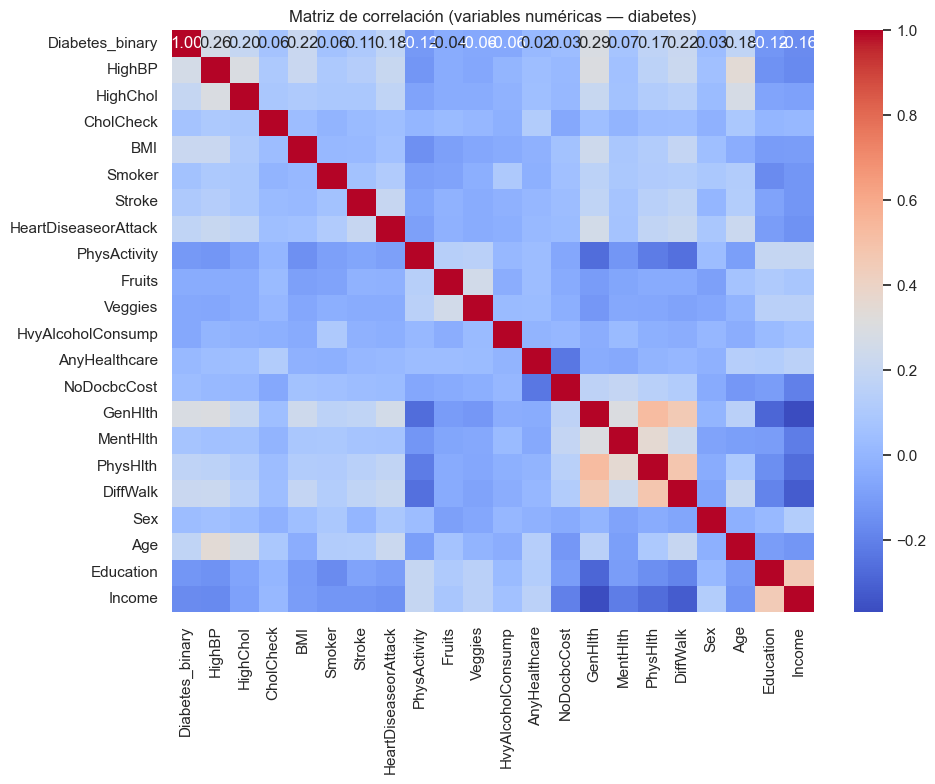

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Usar el dataframe cargado previamente
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (variables numéricas — diabetes)")
plt.tight_layout()
plt.show()


## 4. Desarrollo del modelo KNN

En esta sección entrenamos un modelo **K-Nearest Neighbors** para clasificar a los pacientes según la presencia de diabetes.

### 4.1 Selección de características

Para poder **visualizar la frontera de decisión**, utilizaremos solo **2 variables** como ejemplo:

- `Glucose`  
- `BMI`

La variable objetivo será `Outcome` (0 = No Diabetes, 1 = Diabetes).


In [9]:
feature_cols = ["BMI", "PhysActivity"]   # Ejemplo de 2 variables válidas
target_col = "Diabetes_binary"

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Dimensiones de X:", X.shape)
print("Distribución de la variable objetivo:")
print(y.value_counts(normalize=True))


Dimensiones de X: (253680, 2)
Distribución de la variable objetivo:
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64


### 4.2 División de datos en entrenamiento y prueba

Dividimos el dataset en:

- **80% entrenamiento**  
- **20% prueba**  

Luego aplicamos **escalamiento Min-Max** para que KNN trabaje correctamente (es sensible a la escala de las variables).


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]


array([[0.18604651, 1.        ],
       [0.12790698, 1.        ],
       [0.19767442, 1.        ],
       [0.31395349, 0.        ],
       [0.04651163, 1.        ]])

### 4.3 Creación y entrenamiento del modelo KNN

Comenzamos con un valor inicial de `k = 15` vecinos. Luego mejoraremos este valor con **GridSearchCV**.


Dimensiones de X: (253680, 5)
Distribución de la variable objetivo:
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

✔️ Ejemplo de predicciones: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

📊 Accuracy del modelo: 0.8594

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     43667
         1.0       0.48      0.12      0.19      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.55      0.56     50736
weighted avg       0.82      0.86      0.82     50736



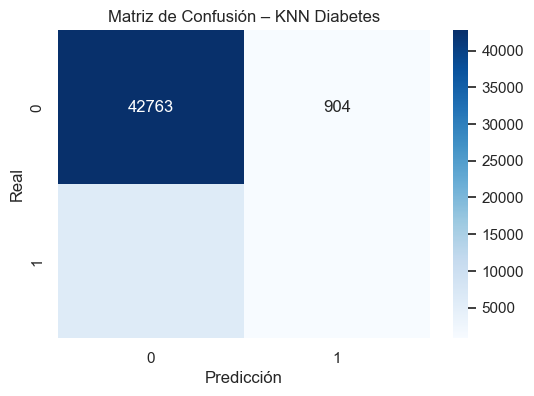

In [14]:
# 4.3 Creación y entrenamiento del modelo KNN — Versión mejorada con más features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Selección de características (todas existen en el dataset)
feature_cols = ["BMI", "PhysActivity", "Age", "Income", "GenHlth"]
target_col = "Diabetes_binary"

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Dimensiones de X:", X.shape)
print("Distribución de la variable objetivo:")
print(y.value_counts(normalize=True))

# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Escalamiento Min-Max
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo KNN
n_neighbors = 25  # valor mejorado para evitar underfitting
modelo_KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
modelo_KNN.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modelo_KNN.predict(X_test_scaled)

print("\n✔️ Ejemplo de predicciones:", y_pred[:10])

# Métricas principales
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 Accuracy del modelo: {acc:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión – KNN Diabetes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### 4.4 Métricas de evaluación

Evaluamos el rendimiento del modelo con:

- **Accuracy**  
- **Precision**  
- **Recall (Sensibilidad)**  
- **F1-Score**  
- **Matriz de confusión**  
- **Especificidad** (Specificity) para el caso binario.


Matriz de confusión:
 [[42763   904]
 [ 6227   842]]

Accuracy: 0.8594489120151372
Precision: 0.4822451317296678
Recall (Sensibilidad): 0.11911161408968737
F1-Score: 0.19103800340328986

Reporte de clasificación completo:

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     43667
         1.0       0.48      0.12      0.19      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.55      0.56     50736
weighted avg       0.82      0.86      0.82     50736



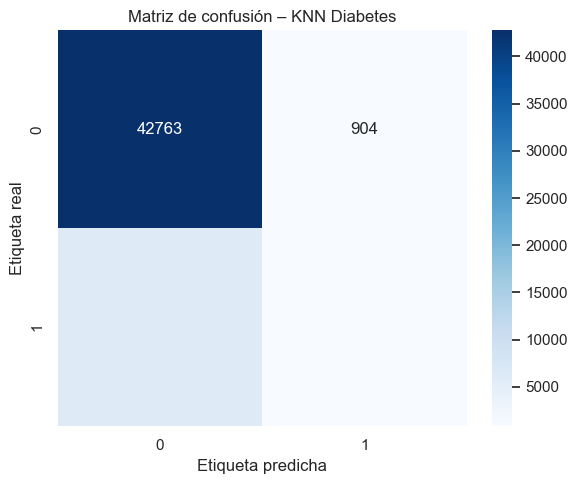

Sensibilidad (Recall): 0.12
Especificidad: 0.98


In [ ]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Matriz de confusión:\n", cm)
print("\nAccuracy:", acc)
print("Precision:", prec)
print("Recall (Sensibilidad):", rec)
print("F1-Score:", f1)

print("\nReporte de clasificación completo:\n")
print(classification_report(y_test, y_pred))

# Grafo de matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión – KNN Diabetes")
plt.tight_layout()
plt.show()

# Sensibilidad y especificidad (solo binario)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensibilidad (Recall): {sensitivity:.2f}")
print(f"Especificidad: {specificity:.2f}")

#Puede arrojar datos desvalanceados :)

### 4.5 Frontera de decisión en 2D

Utilizando solo `Glucose` y `BMI` como características, graficamos la **frontera de decisión** del modelo KNN para entender cómo separa las clases.


In [ ]:
# =========================================================
# 4.5 Visualización PCA 2D del modelo KNN (compatible con múltiples features)
# =========================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Aplicar PCA para reducir X_train_scaled a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Convertir test también
X_test_pca = pca.transform(X_test_scaled)

# Predicciones
y_pred = modelo_KNN.predict(X_test_scaled)

# ---------------------------------------------------------
# Gráfico PCA 2D
# ---------------------------------------------------------
plt.figure(figsize=(10, 7))

sns.scatterplot(
    x=X_test_pca[:, 0],
    y=X_test_pca[:, 1],
    hue=y_pred,
    palette=["#1f77b4", "#ff7f0e"],
    style=y_test.to_numpy(),
    alpha=0.7,
    s=40
)

plt.title("Visualización PCA 2D — Modelo KNN para Diagnóstico de Diabetes", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")

# Leyenda personalizada
import matplotlib.patches as Patch
patch0 = Patch.Patch(color="#1f77b4", label="Predicción: No Diabetes (0)")
patch1 = Patch.Patch(color="#ff7f0e", label="Predicción: Diabetes (1)")
plt.legend(handles=[patch0, patch1])

plt.grid(True)
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:19                                                                                   │
│                                                                                                  │
│   16 X_grid = np.c_[xx.ravel(), yy.ravel()]                                                      │
│   17                                                                                             │
│   18 # Predecir clases en la malla                                                               │
│ ❱ 19 Z = modelo_KNN.predict(X_grid)                                                              │
│   20 Z = Z.reshape(xx.shape)                                                                     │
│   21                                                                                             │
│   22 cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA"])  # fondo                                │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:271 in  │
│ predict                                                                                          │
│                                                                                                  │
│   268 │   │   │   │   return self.classes_[np.argmax(probabilities, axis=1)]                     │
│   269 │   │   │   # In that case, we do not need the distances to perform                        │
│   270 │   │   │   # the weighting so we do not compute them.                                     │
│ ❱ 271 │   │   │   neigh_ind = self.kneighbors(X, return_distance=False)                          │
│   272 │   │   │   neigh_dist = None                                                              │
│   273 │   │   else:                                                                              │
│   274 │   │   │   neigh_dist, neigh_ind = self.kneighbors(X)                                     │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\neighbors\_base.py:825 in kneighbors │
│                                                                                                  │
│    822 │   │   │   if self.metric == "precomputed":                                              │
│    823 │   │   │   │   X = _check_precomputed(X)                                                 │
│    824 │   │   │   else:                                                                         │
│ ❱  825 │   │   │   │   X = self._validate_data(X, accept_sparse="csr", reset=False, order="C")   │
│    826 │   │                                                                                     │
│    827 │   │   n_samples_fit = self.n_samples_fit_                                               │
│    828 │   │   if n_neighbors > n_samples_fit:                                                   │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\base.py:654 in _validate_data        │
│                                                                                                  │
│    651 │   │   │   out = X, y                                                                    │
│    652 │   │                                                                                     │
│    653 │   │   if not no_val_X and check_params.get("ensure

### 4.6 Curva ROC

Calculamos la **curva ROC** y el **AUC** para evaluar el desempeño global del modelo en términos de tasa de falsos positivos y verdaderos positivos.


In [ ]:
y_pred_proba = modelo_KNN.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC – KNN Diabetes")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.7 Curva Precision-Recall (PR)

La curva **Precision-Recall** es especialmente útil cuando la clase positiva (diabetes) está desbalanceada.


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(7, 5))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot(ax=ax)
ax.set_title(f"Curva Precision-Recall – KNN (AP = {ap_score:.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.8 Búsqueda de hiperparámetros con GridSearchCV

Finalmente, usamos **GridSearchCV** para encontrar el mejor número de vecinos `k` en el rango de 1 a 30.

Luego evaluamos nuevamente el modelo óptimo en el conjunto de prueba.


In [ ]:
param_grid = {"n_neighbors": np.arange(1, 31)}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor accuracy (cross-validation):", grid_search.best_score_)

best_knn = grid_search.best_estimator_
test_accuracy = best_knn.score(X_test_scaled, y_test)
print("Accuracy en test con mejores parámetros:", test_accuracy)

y_pred_gs = best_knn.predict(X_test_scaled)

print("\nReporte de clasificación (mejor modelo):\n")
print(classification_report(y_test, y_pred_gs))

cm_best = confusion_matrix(y_test, y_pred_gs)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – KNN (GridSearchCV)")
plt.tight_layout()
plt.show()

print("Accuracy Score (GridSearchCV):", accuracy_score(y_test, y_pred_gs))

# Sensibilidad y especificidad del mejor modelo
tn_b, fp_b, fn_b, tp_b = cm_best.ravel()
sensitivity_best = tp_b / (tp_b + fn_b)
specificity_best = tn_b / (tn_b + fp_b)

print(f"\nSensibilidad (Best Model): {sensitivity_best:.4f}")
print(f"Especificidad (Best Model): {specificity_best:.4f}")


### 4.9 Curvas ROC y PR para el mejor modelo

Repetimos el análisis de curvas ROC y Precision-Recall usando el **mejor modelo** encontrado por GridSearchCV.


In [ ]:
# Probabilidades para la clase positiva
y_pred_proba_best = best_knn.predict_proba(X_test_scaled)[:, 1]

# === Curva ROC ===
fpr_b, tpr_b, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc_b = auc(fpr_b, tpr_b)

plt.figure(figsize=(7, 5))
plt.plot(fpr_b, tpr_b, color="darkorange", lw=2, label=f"ROC (AUC = {roc_auc_b:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.title("Curva ROC – Mejor KNN (GridSearchCV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Curva Precision-Recall ===
precision_b, recall_b, _ = precision_recall_curve(y_test, y_pred_proba_best)
ap_b = average_precision_score(y_test, y_pred_proba_best)

plt.figure(figsize=(7, 5))
plt.plot(recall_b, precision_b, color="blue", lw=2, label=f"PR (AP = {ap_b:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall – Mejor KNN (GridSearchCV)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()
